### Optymalizacja - problem przeszukiwania

Lista skupia się na implementacji dwóch algorytmów z wykorzystaniem heurystyk i jednej metaheurystyki w problemie odnajdywania najkrótszych ścieżek

#### Założenia
Jednym z problemów jest uwzględnienie czasu przesiadki do innej linii lub na pobliski przystanek - tutaj zostały rozważone dwa podejścia, gdzie nie dodajemy czasu przesiadki (0 s.) oraz gdzie go dodajemy (60 s.). Prowadzi to do interesujących wniosków. Kolejnym z założeń jest to, że będąc na przystanku o danej nazwie mogę się przejść na pobliski przystanek o tej samej nazwie - dzięki temu odkrywane jest więcej połączeń. 

#### Zbiór testowy
ALgorytmy zostały przetestowane na zbiorze 18-stu przejazdów o różnych poziomach skomplikowania trasy. Większy nacisk kładziony był na sprawdzenie poprawności niż wydajności rozwiązania.

#### 1. Dijkstra 

Jest to algorytm zachłanny wybierający zawsze węzeł o najmniejszej wartości funkcji kosztu $f$. W tym przypadku wykorzystana została zmodyfikowana implementacja, która jest oparta na kolejce priorytetowej. 

Sama idea przeszukiwania wierzchołków w optymalizacji czasu sprowadza się do następujących kroków:
1. Zainicjalizuj kolejkę przystankiem początkowym (z odpowiadającym sztucznym połączeniem)
2. Wybierz przystanek o najmniejszym koszcie - koszt jest obliczany na podstawie najszybszego połączenia, które nas doprowadzi do tego przystanku
3. Dla tego przystanku rozważ najszybsze połączenia z *wszystkich* przystanków o tej nazwie do sąsiadujących przystanków, które jeszcze nie zostały odwiedzone
4. Dodaj ten przystanek do listy odwiedzonych
2. Powtarzaj póki kolejka nie jest pusta

In [9]:
import pandas as pd
import numpy as np
from ai_data_eng.searching.globals import *
from ai_data_eng.searching.searchning import print_path_mark_stops, print_path
from ai_data_eng.searching.utils import *
from ai_data_eng.searching.plottings import *
from ai_data_eng.searching.a_star_p.a_star_changes_opt import a_star_p_solution
from ai_data_eng.searching.a_star_t.a_star_time_opt import a_star_t_solution
from ai_data_eng.searching.a_star import a_star_solution
from ai_data_eng.searching.dijkstra import dijkstra_solution

import matplotlib.pyplot as plt 
RESULTS = DATA_DIR / 'results'

In [10]:
conn, sol_cost, elapsed_time = dijkstra_solution('DWORZEC NADODRZE', 'Młodych Techników', '16:00:00')

C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\searching\searchning.py:133: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  connection_graph = pd.read_csv(DATA_DIR / 'connection_graph.csv',


In [11]:
print_path(conn)
print(f"{sec_to_time(sol_cost)}, {elapsed_time:.2f}s")

(0) DWORZEC NADODRZE [16:00:00] --- 14 ---> Paulińska [16:02:00] [255474]
(1) Paulińska [16:02:00] --- 144 ---> Dubois [16:04:00] [818315]
(2) Dubois [16:04:00] --- 144 ---> Pomorska [16:06:00] [818316]
(3) Pomorska [16:06:00] --- 144 ---> Kępa Mieszczańska [16:08:00] [818317]
(4) Kępa Mieszczańska [16:08:00] --- 144 ---> PL. JANA PAWŁA II [16:10:00] [818318]
(5) PL. JANA PAWŁA II [16:10:00] --- 13 ---> Młodych Techników [16:12:00] [232310]
00:12:00, 9.09s


In [12]:
header = ['start_stop', 'goal_stop', 'commuting_time', 'changes', 'elapsed_time', 'cost', 'change_time']
dij = pd.read_csv(RESULTS / 'dijkstra/summary0', names=header)

In [13]:
dij

,start_stop,goal_stop,commuting_time,changes,elapsed_time,cost,change_time
0,PL. GRUNWALDZKI,most Grunwaldzki,00:01:00,0,2.95,60,0
1,PL. GRUNWALDZKI,Renoma,00:09:00,1,7.46,540,0
2,KLECINA,OSIEDLE SOBIESKIEGO,00:54:00,5,43.30,3240,0
3,Broniewskiego,Uniwersytet Ekonomiczny,00:32:00,3,29.88,1920,0
4,POŚWIĘTNE,Młodych Techników,00:27:00,2,15.40,1620,0
5,Śliczna,Marchewkowa,01:01:00,3,32.38,3660,0
6,KOSZAROWA (Szpital),Buforowa-Rondo,02:06:00,5,47.44,7560,0
7,Wilczyce - Dębowa,Marszowicka,05:42:00,6,45.87,20520,0
8,Zabrodzie - pętla,Wiślańska,01:53:00,6,41.44,6780,0
9,Maślicka (Osiedle),Iwiny - Kolejowa,01:08:00,8,45.86,4080,0


### 2. A$^{*}$

Implementacja tego algorytmu różni się od tej teoretycznej - jest również oparta na kolejce priorytetowej, gdzie waga wierzchołka jest równa $f + g$, gdzie g to użyta heurystyka. 

##### Optymalizacja czasu 
W tym przypadku logika jest podobna jak w dijkstrze, gdzie użyta heurystyka stara się oszacować pozostały czas. Jest to trudne ponieważ nie wiemy z jaką prędkością porusza się środek transportu oraz jak zawiła jest jego trasa. Na podstawie eksperymentów została wybrana heurystyka, która przyjmuje dwa hiperparametry - $v$ oraz $alpha$, gdzie $v$ to początkowa, przeszacowana prędkość a $alpha$ to mały współczynnik aktualizacji prędkości o chwilową prędkość aktualnego połączenia. Jest to więc heurystyka 'ucząca' się a parametry zostały wybrane na podstawie paru różnych tras. Problemem jest jednak udowodnienie, że jest to heurystyka optymistyczna, więc najlepszym środkiem jest porównanie wyników do działania dijsktry.

In [14]:
conn, sol_cost, elapsed_time = a_star_solution('DWORZEC NADODRZE', 'Młodych Techników', '16:00:00', 't')

C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\searching\searchning.py:133: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  connection_graph = pd.read_csv(DATA_DIR / 'connection_graph.csv',


In [15]:
print_path(conn)
print(f"{sec_to_time(sol_cost)}, {elapsed_time:.2f}s")

(0) DWORZEC NADODRZE [16:00:00] --- 14 ---> Paulińska [16:02:00] [255474]
(1) Paulińska [16:02:00] --- 144 ---> Dubois [16:04:00] [818315]
(2) Dubois [16:04:00] --- 144 ---> Pomorska [16:06:00] [818316]
(3) Pomorska [16:06:00] --- 144 ---> Kępa Mieszczańska [16:08:00] [818317]
(4) Kępa Mieszczańska [16:08:00] --- 144 ---> PL. JANA PAWŁA II [16:10:00] [818318]
(5) PL. JANA PAWŁA II [16:10:00] --- 13 ---> Młodych Techników [16:12:00] [232310]
00:12:00, 4.46s


In [16]:
a_star_t = pd.read_csv(RESULTS / 'a-star-t/summary0', names=header)

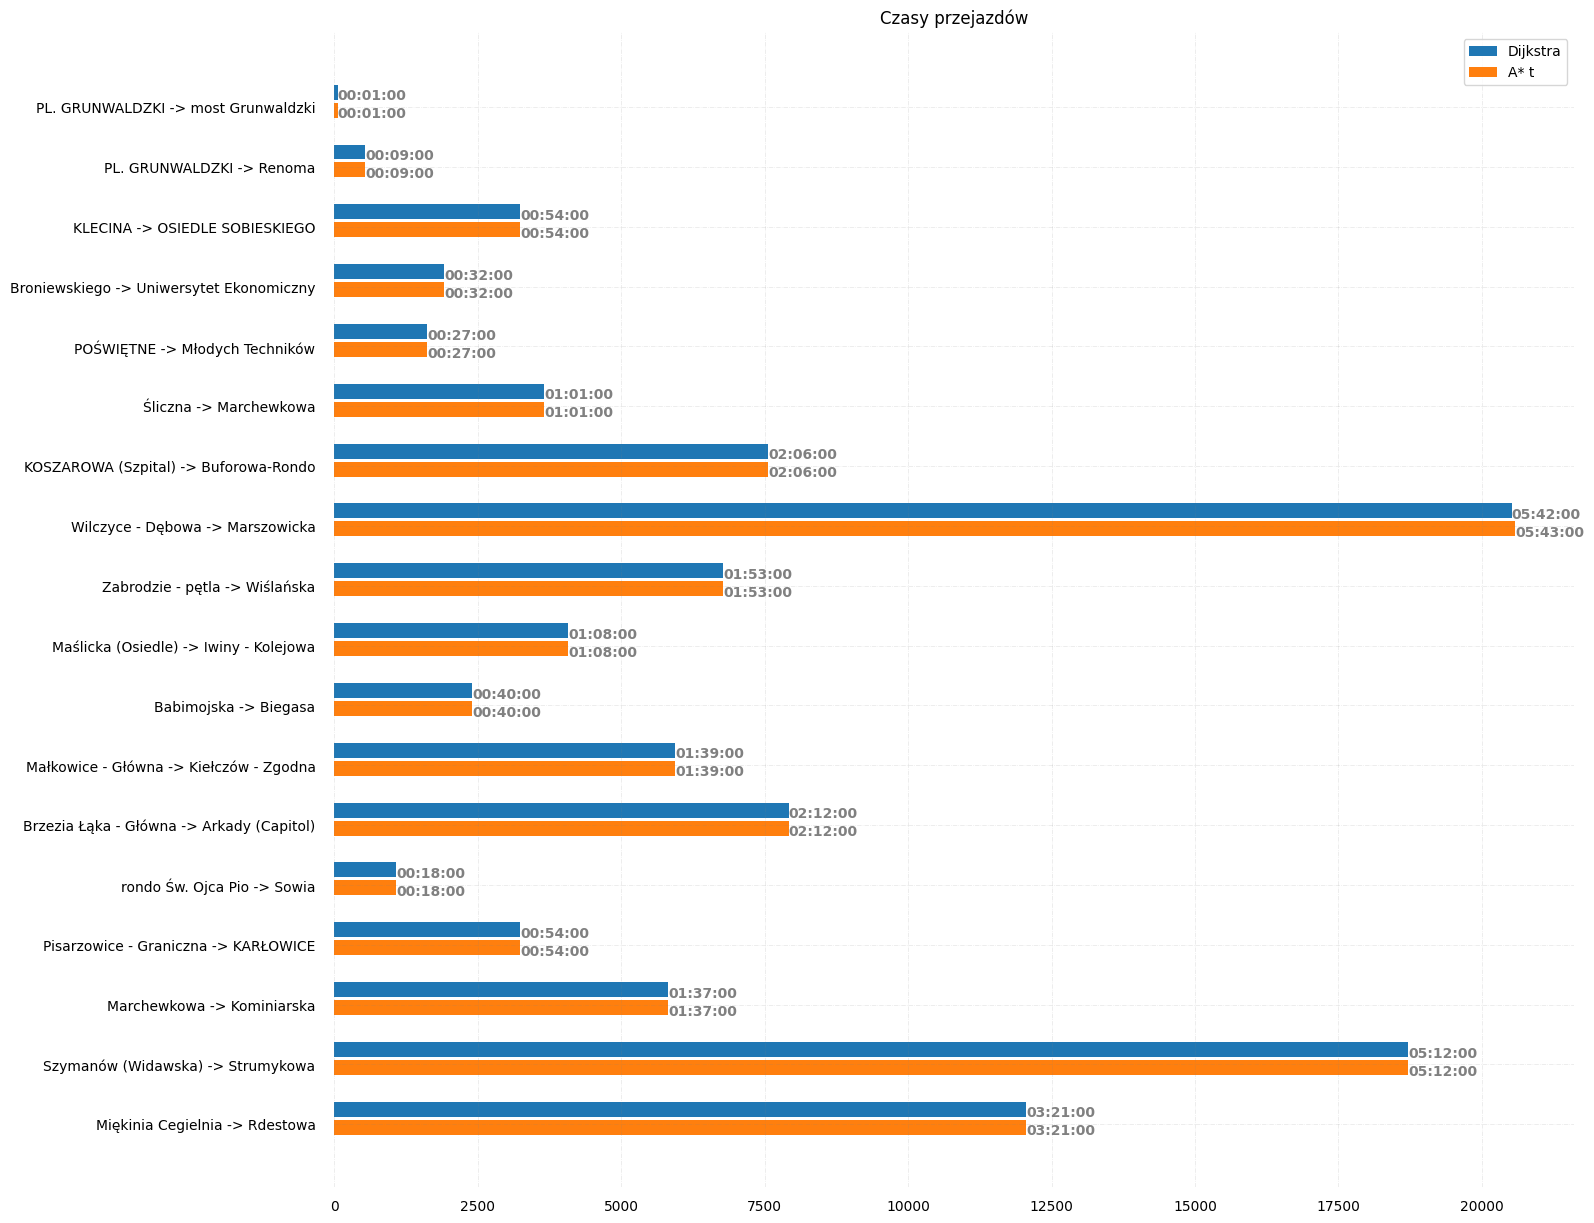

In [17]:
bar_plot_compare([dij, a_star_t], ['Dijkstra', 'A* t'], col_idx=2, title='Czasy przejazdów', formatter=time_to_normalized_sec, display_annotation=True)

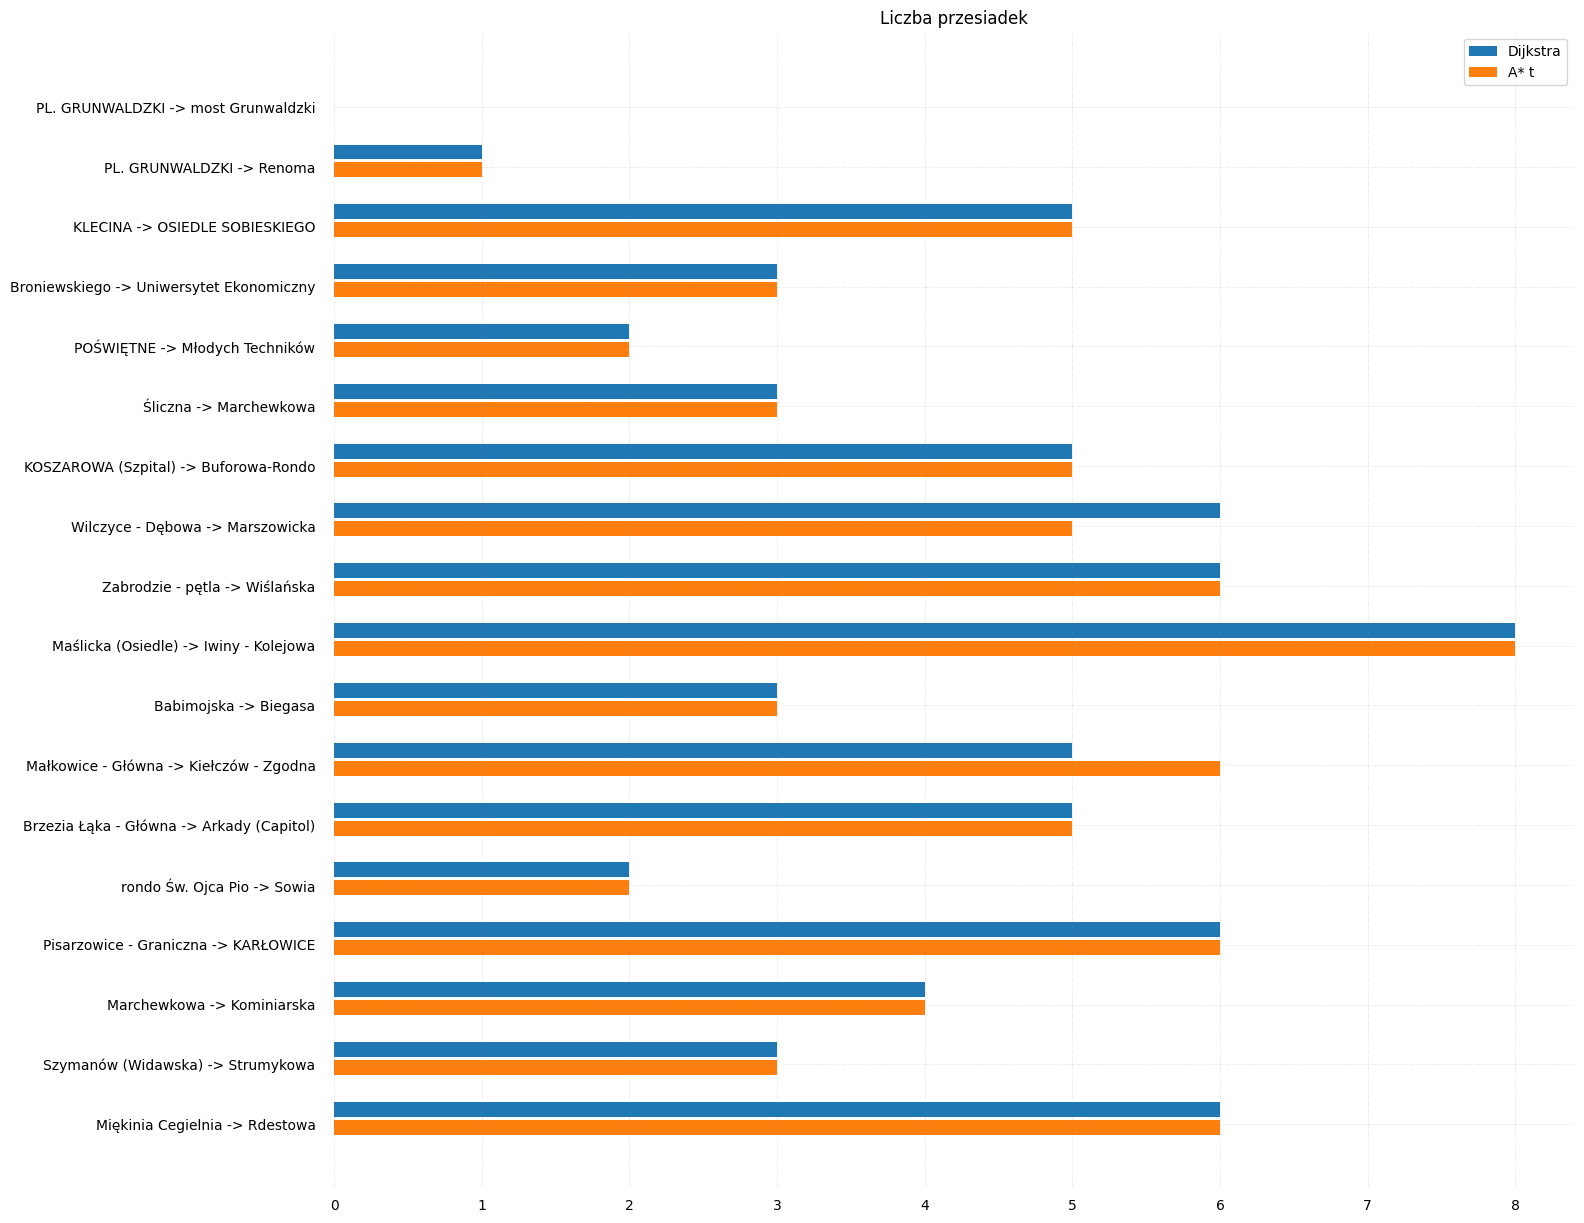

In [18]:
bar_plot_compare([dij, a_star_t], ['Dijkstra', 'A* t'], col_idx=3, title='Liczba przesiadek', formatter=int, display_annotation=False)

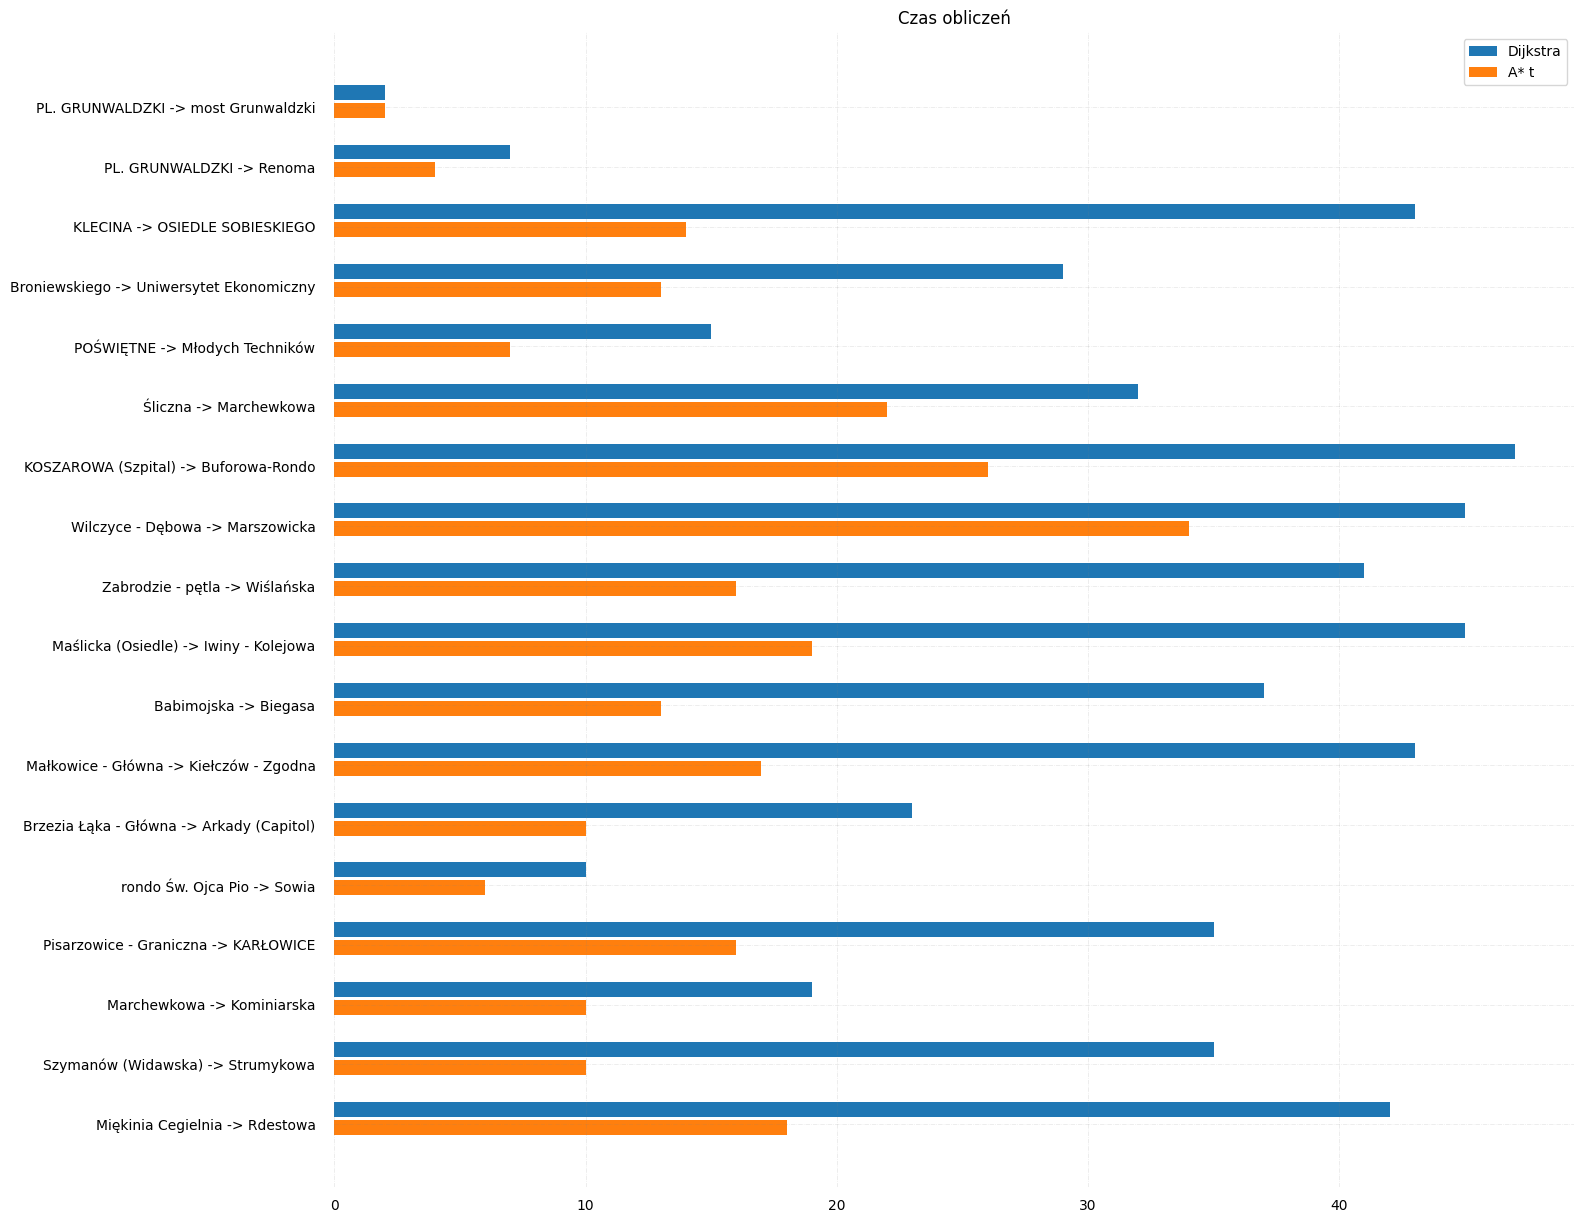

In [19]:
bar_plot_compare([dij, a_star_t], ['Dijkstra', 'A* t'], col_idx=4, title='Czas obliczeń', formatter=int, display_annotation=False)

#### Modyfikacja - dodanie czasu przesiadki 

W celu urealnienia sytuacji zmiany linii dodano do algorytmów stałą wartość przesiadki - 1 min. W niektórych przypadkach zwiększyło to całkowity czas przejazdu i zmieniło liczbę przesiadek. 

In [20]:
a_star_t_60 = pd.read_csv(RESULTS / 'a-star-custom/summary60', names=header)
dij_60 = pd.read_csv(RESULTS / 'dijkstra/summary60', names=header)

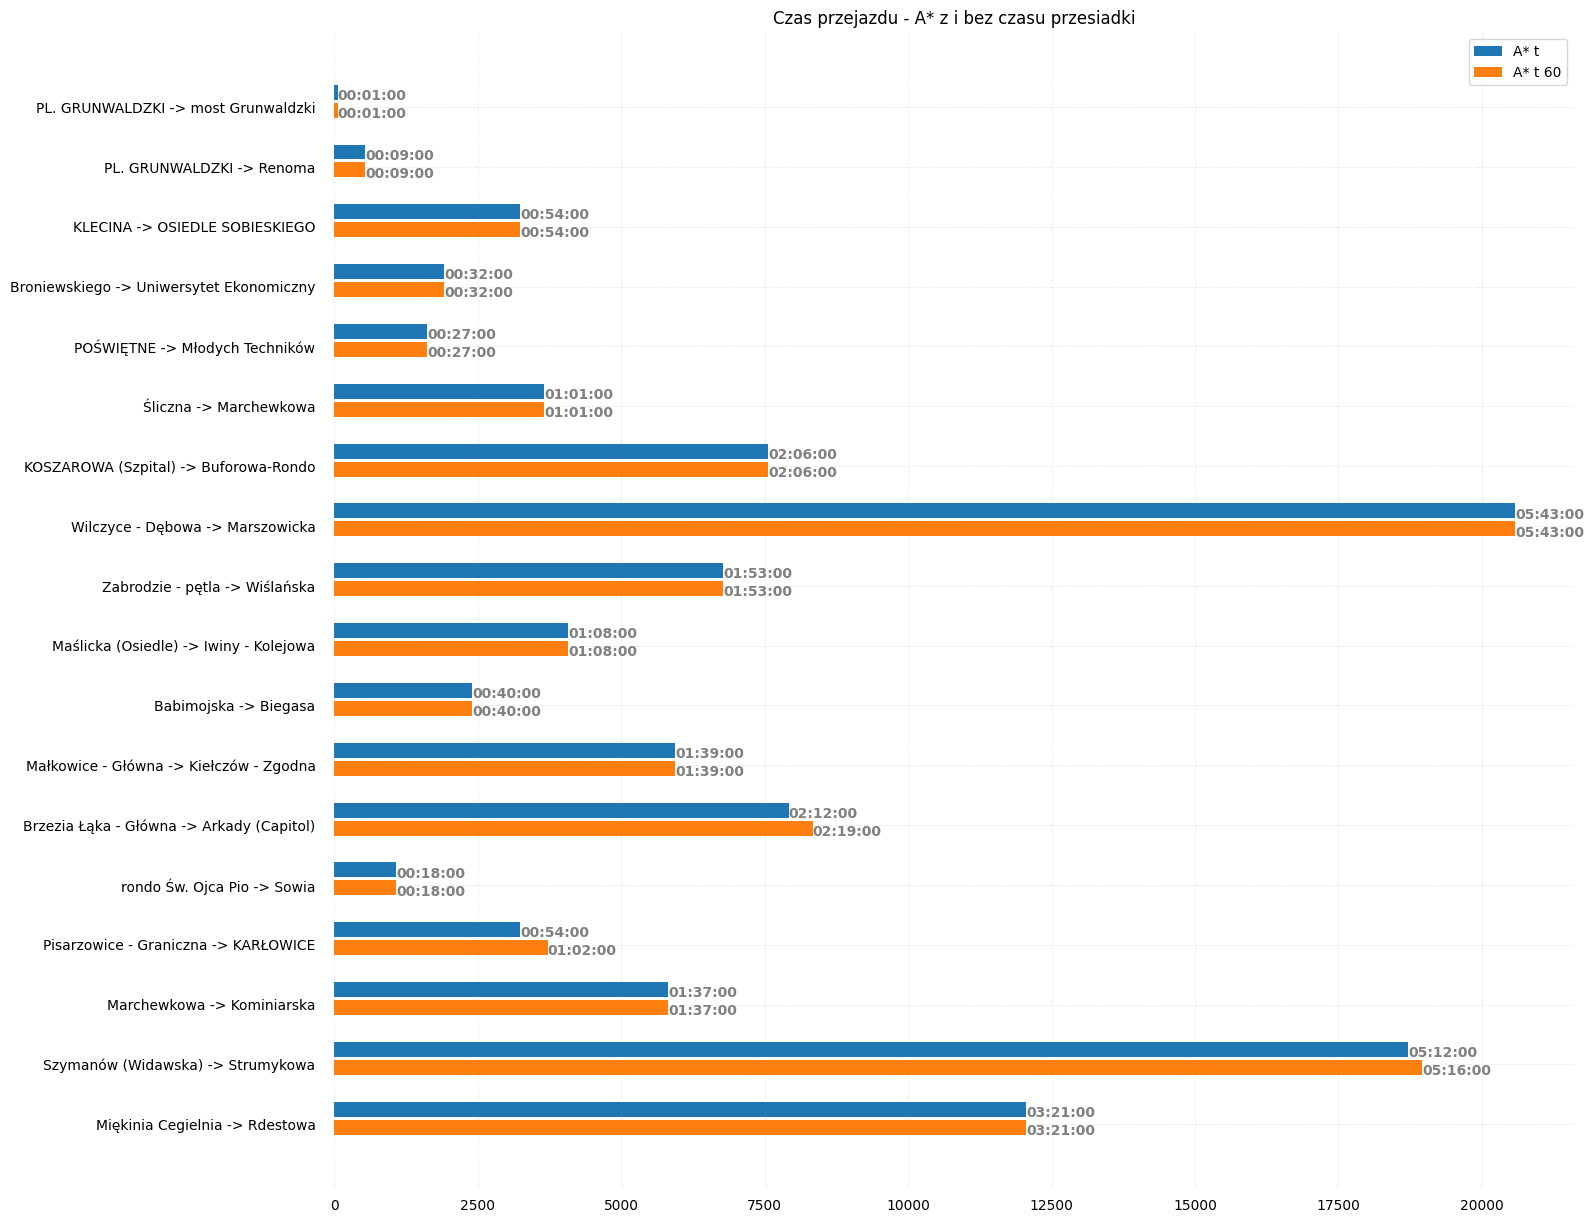

In [21]:
bar_plot_compare([a_star_t, a_star_t_60], ['A* t', 'A* t 60'], col_idx=2, title='Czas przejazdu - A* z i bez czasu przesiadki', 
                 formatter=time_to_normalized_sec, display_annotation=True)

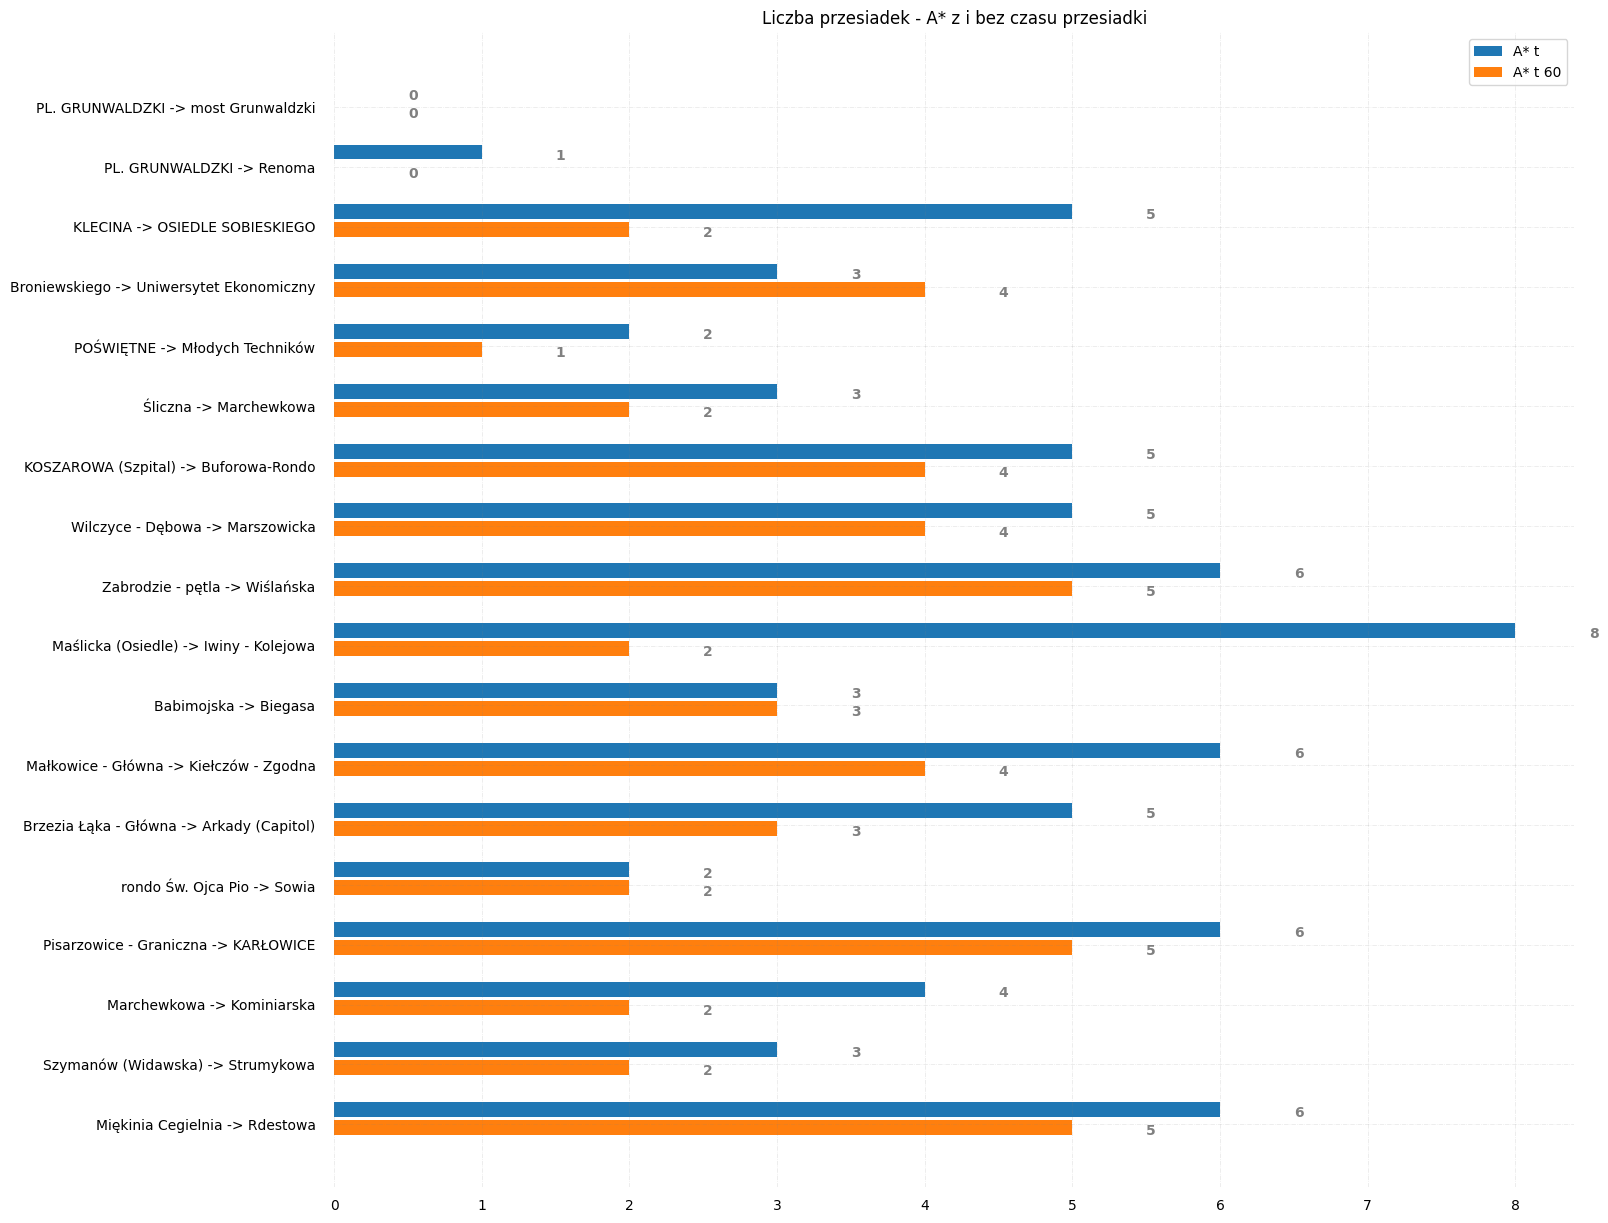

In [22]:
bar_plot_compare([a_star_t, a_star_t_60], ['A* t', 'A* t 60'], col_idx=3, title='Liczba przesiadek - A* z i bez czasu przesiadki', 
                 formatter=int, display_annotation=True)

W przypadku Dijkstry dodanie czasu przesiadki nie działa dla tej implementacji, ponieważ zachłanne podejście nie sprawdza się tutaj (musielibyśmy dodać do informacji o węzłach linię, którą podróżujemy).

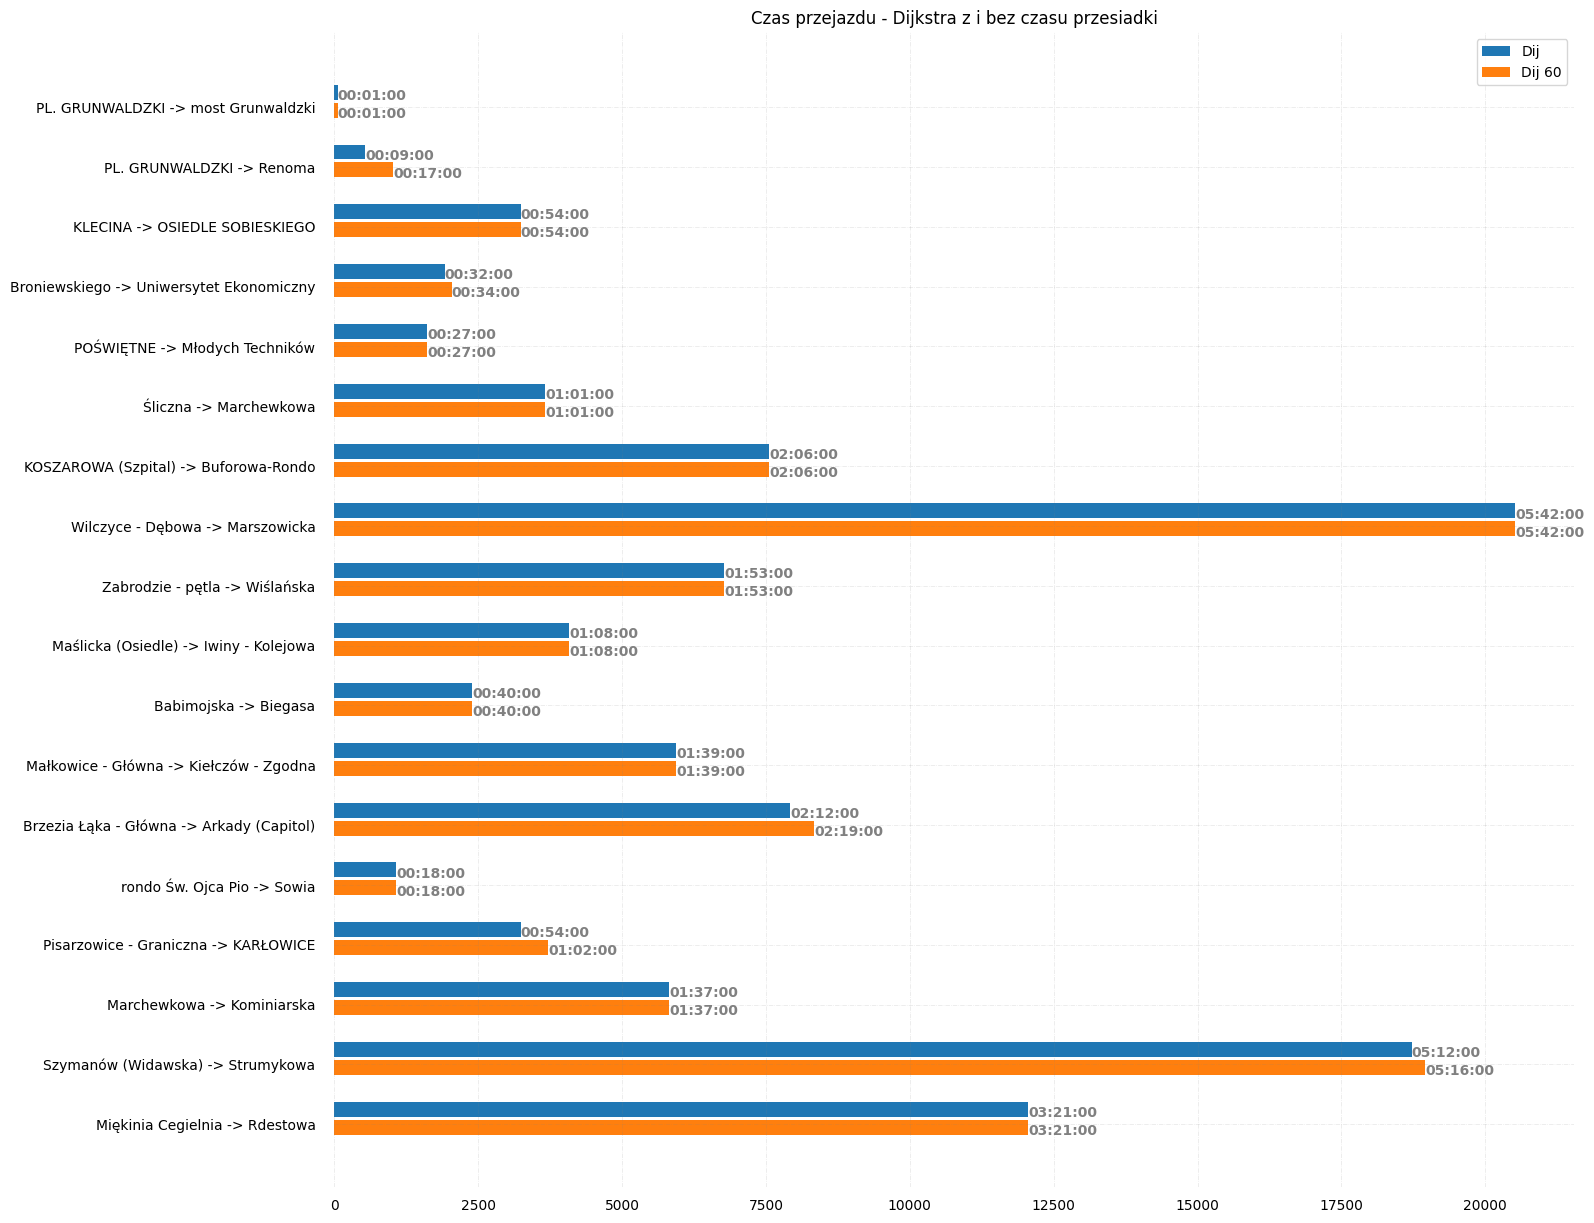

In [23]:
bar_plot_compare([dij, dij_60], ['Dij', 'Dij 60'], col_idx=2, title='Czas przejazdu - Dijkstra z i bez czasu przesiadki', 
                 formatter=time_to_normalized_sec, display_annotation=True)

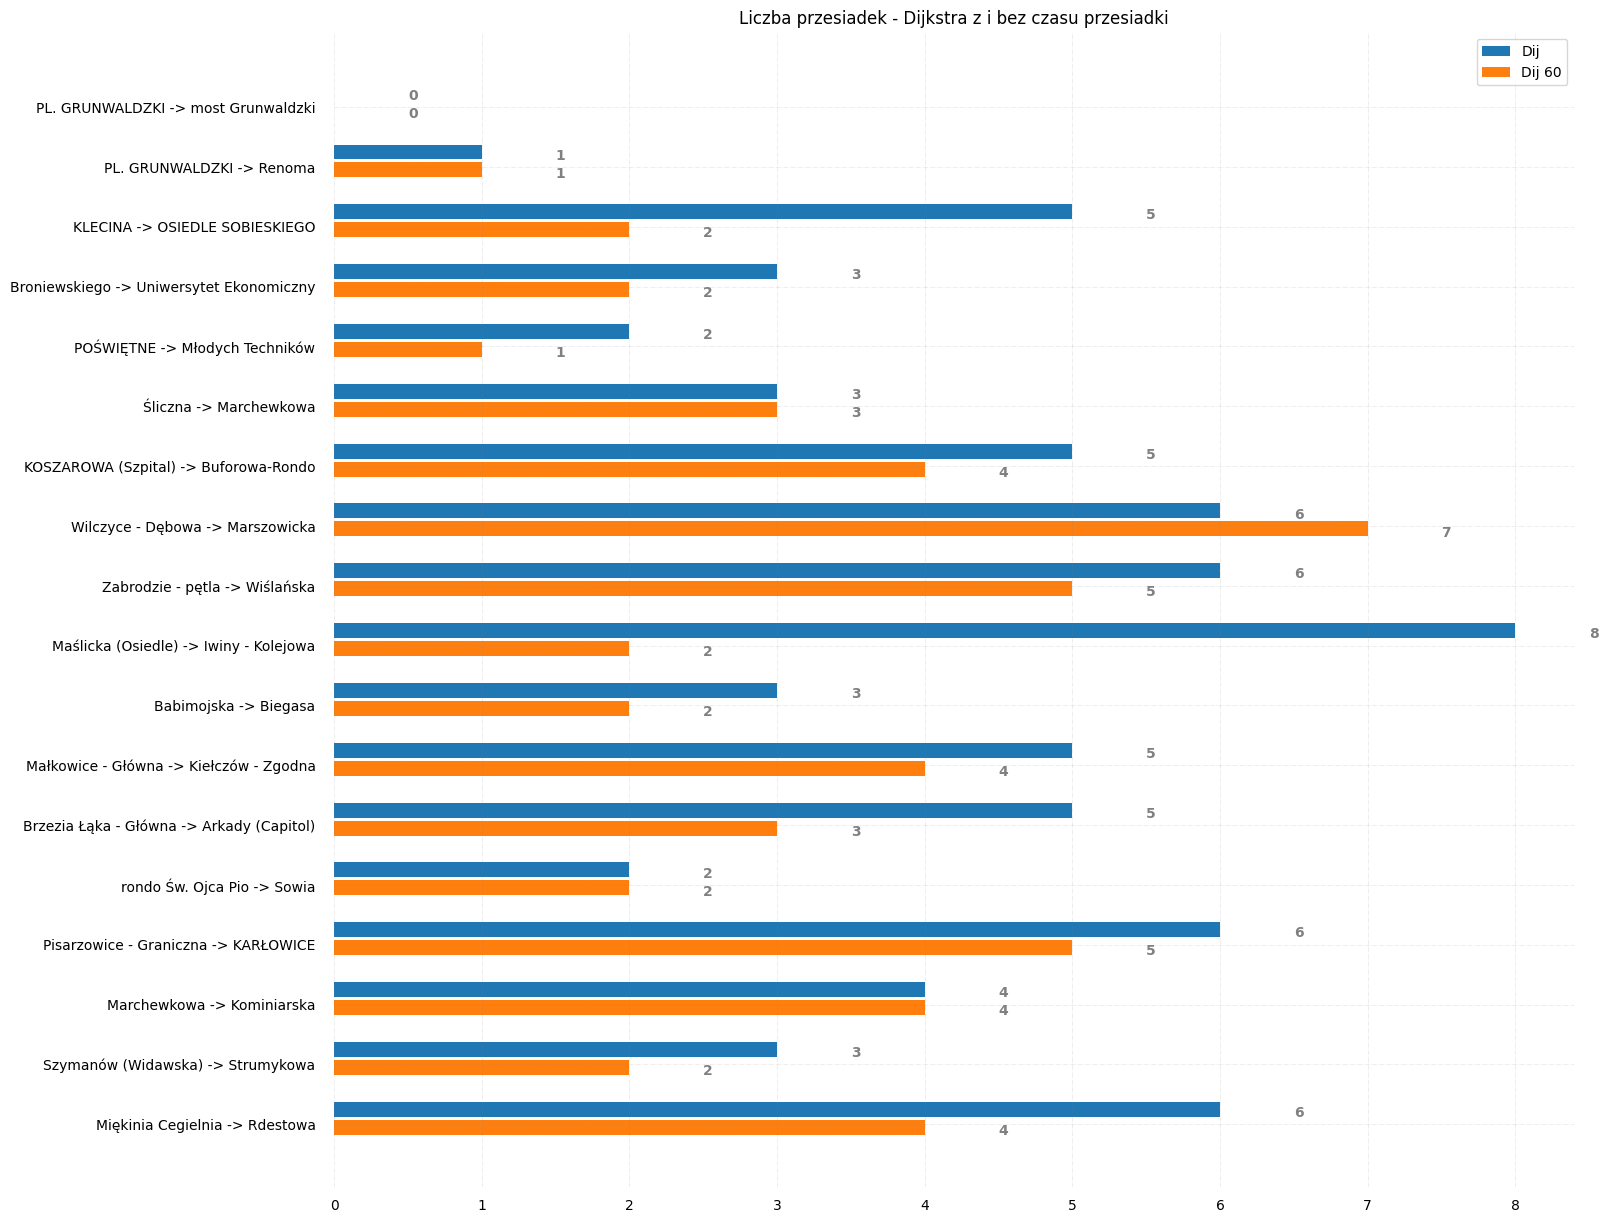

In [24]:
bar_plot_compare([dij, dij_60], ['Dij', 'Dij 60'], col_idx=3, title='Liczba przesiadek - Dijkstra z i bez czasu przesiadki', 
                 formatter=int, display_annotation=True)

#### Optymalizacja przesiadek
Ta postać problemu była bardziej skomplikowana ponieważ definicja przesiadki nie jest oczywista. W tym przypadku uznano, że doszło do przesiadki gdy
- nastąpiła zmiana lini
- nastąpiło przejście do sąsiedniego przystanku
- czas między przyjazdem a odjazdem jest 'długi' (bez tego wpadamy w przejazdy z innego kursu), jako maksymalną długość przejazdu między przystankami przyjęto 99 percentyl czasu między przejazdami dla tego zbioru, czyli 4 minuty.

Heurystyka polega na oszacowaniu liczby przesiadek w zależności od odległości od przystanku końcowego i aktualnej, już dokonanej liczby przesiadek. Heurystyka również faworyzuje początkowe połączenie, które jest najszybciej (tj. by zacząć podróż jak najszybciej).

Reprezentacja połączeń różni się od $A^* t$ tym, że przeszukujemy wszystkie możliwe linie wychodzące z danego przystanku, jak i zachowujemy informację o lini w węźle grafu. 

In [25]:
conn, sol_cost, elapsed_time = a_star_solution('DWORZEC NADODRZE', 'Młodych Techników', '16:00:00', 'p')

C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\searching\searchning.py:133: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  connection_graph = pd.read_csv(DATA_DIR / 'connection_graph.csv',


In [26]:
print_path(conn)
print(f"{sol_cost}, {elapsed_time:.2f}s")

(0) DWORZEC NADODRZE [16:11:00] --- 132 ---> Paulińska [16:13:00] [735117]
(1) Paulińska [16:13:00] --- 132 ---> Dubois [16:16:00] [735118]
(2) Dubois [16:16:00] --- 132 ---> Rynek [16:21:00] [735119]
(3) Rynek [16:21:00] --- 132 ---> PL. JANA PAWŁA II [16:24:00] [735120]
(4) PL. JANA PAWŁA II [16:24:00] --- 132 ---> Młodych Techników [16:26:00] [735121]
0, 9.83s


In [27]:
a_star_p = pd.read_csv(DATA_DIR / 'debug-new/a-star-p/summary0', names=header)

In [28]:
a_star_p.head()

,start_stop,goal_stop,commuting_time,changes,elapsed_time,cost,change_time
0,PL. GRUNWALDZKI,most Grunwaldzki,00:01:00,0,2.99,0,0
1,PL. GRUNWALDZKI,Renoma,00:09:00,0,3.90,0,0
2,KLECINA,OSIEDLE SOBIESKIEGO,00:54:00,0,10.58,0,0
3,Broniewskiego,Uniwersytet Ekonomiczny,00:37:00,0,10.04,0,0
4,POŚWIĘTNE,Młodych Techników,13:11:00,1,10.53,1,0


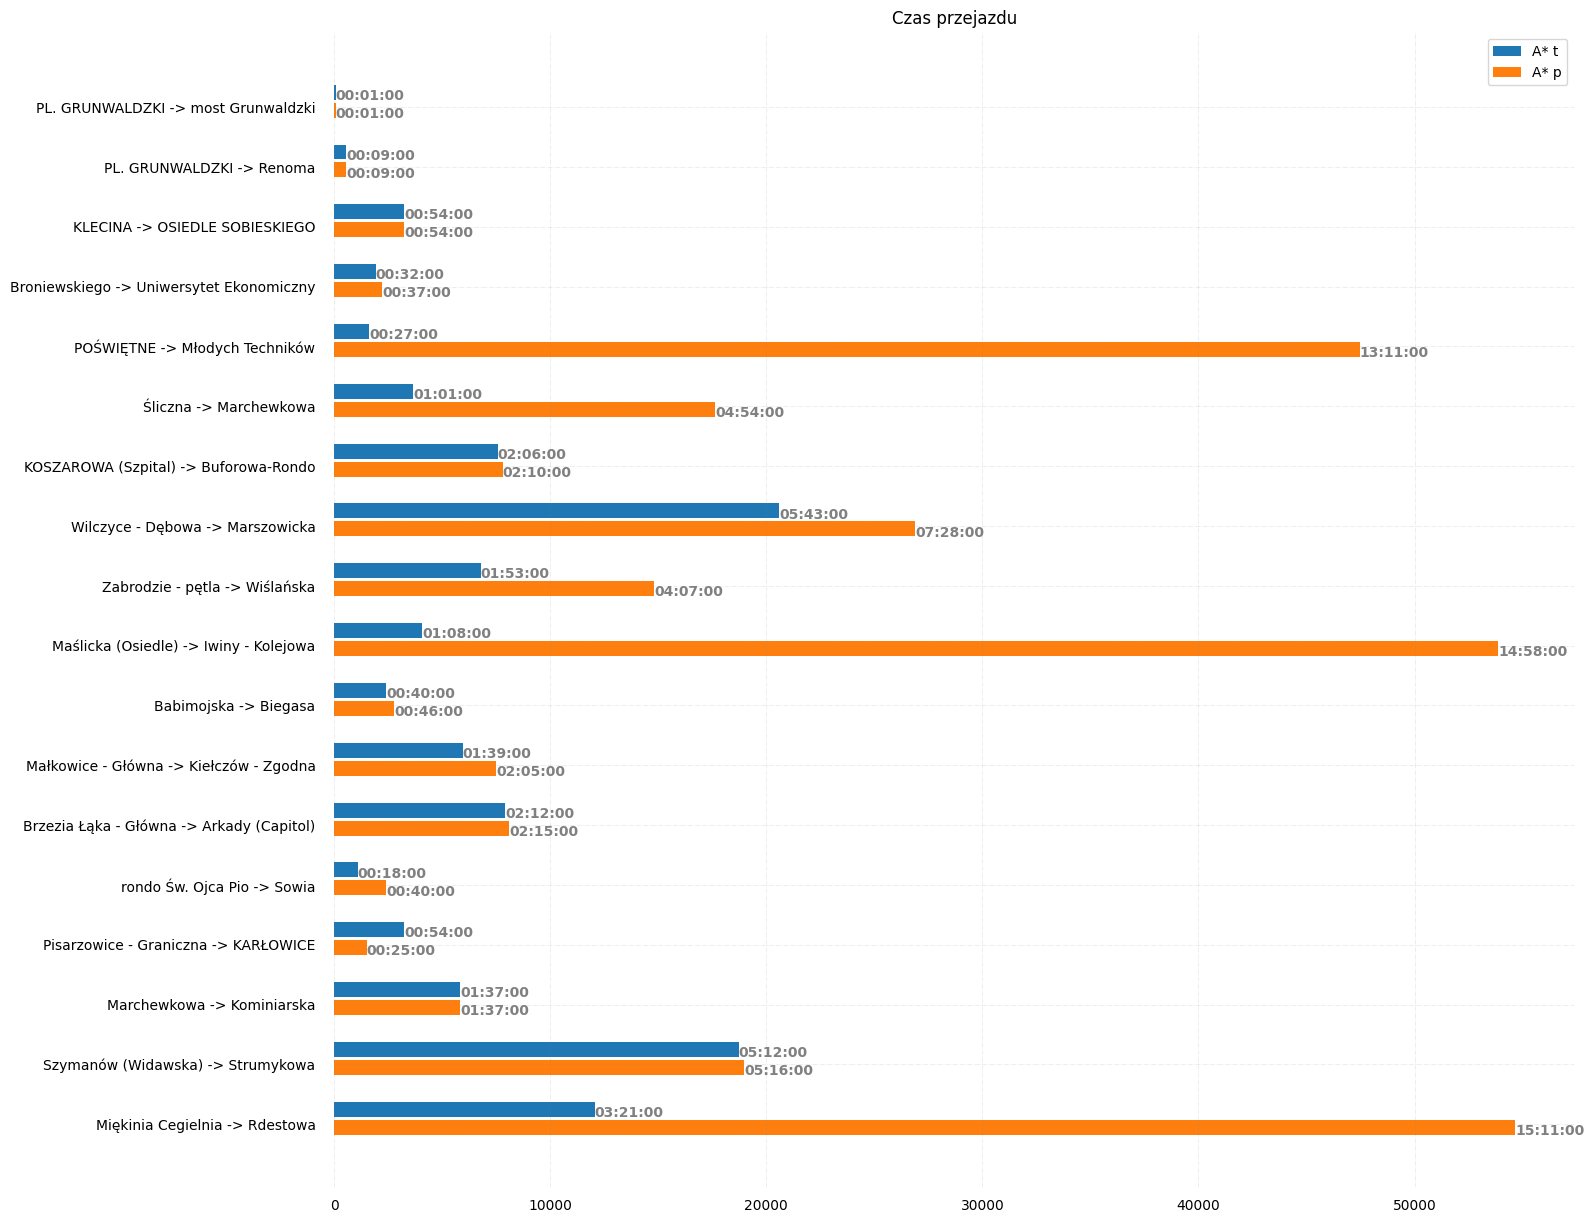

In [29]:
bar_plot_compare([a_star_t, a_star_p], ['A* t', 'A* p'], col_idx=2, title='Czas przejazdu', formatter=time_to_normalized_sec, display_annotation=True)

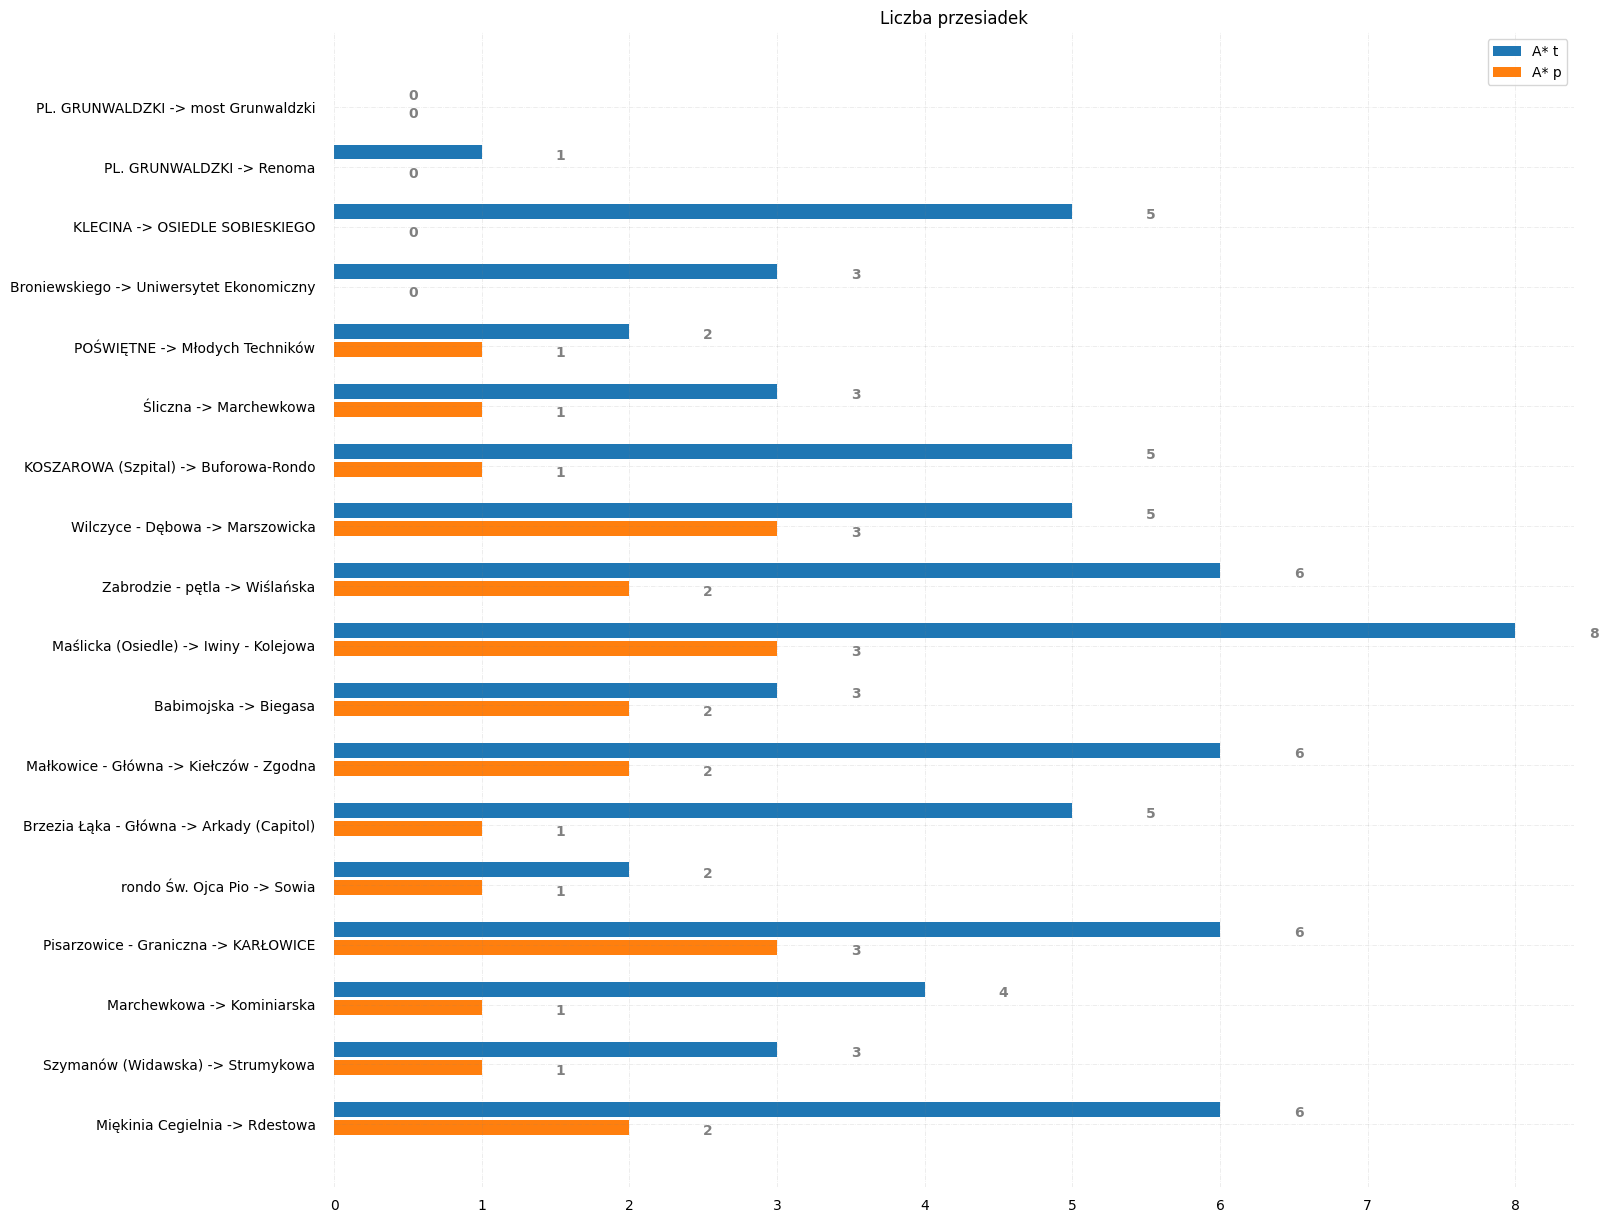

In [30]:
bar_plot_compare([a_star_t, a_star_p], ['A* t', 'A* p'], col_idx=3, title='Liczba przesiadek', formatter=int, display_annotation=True)

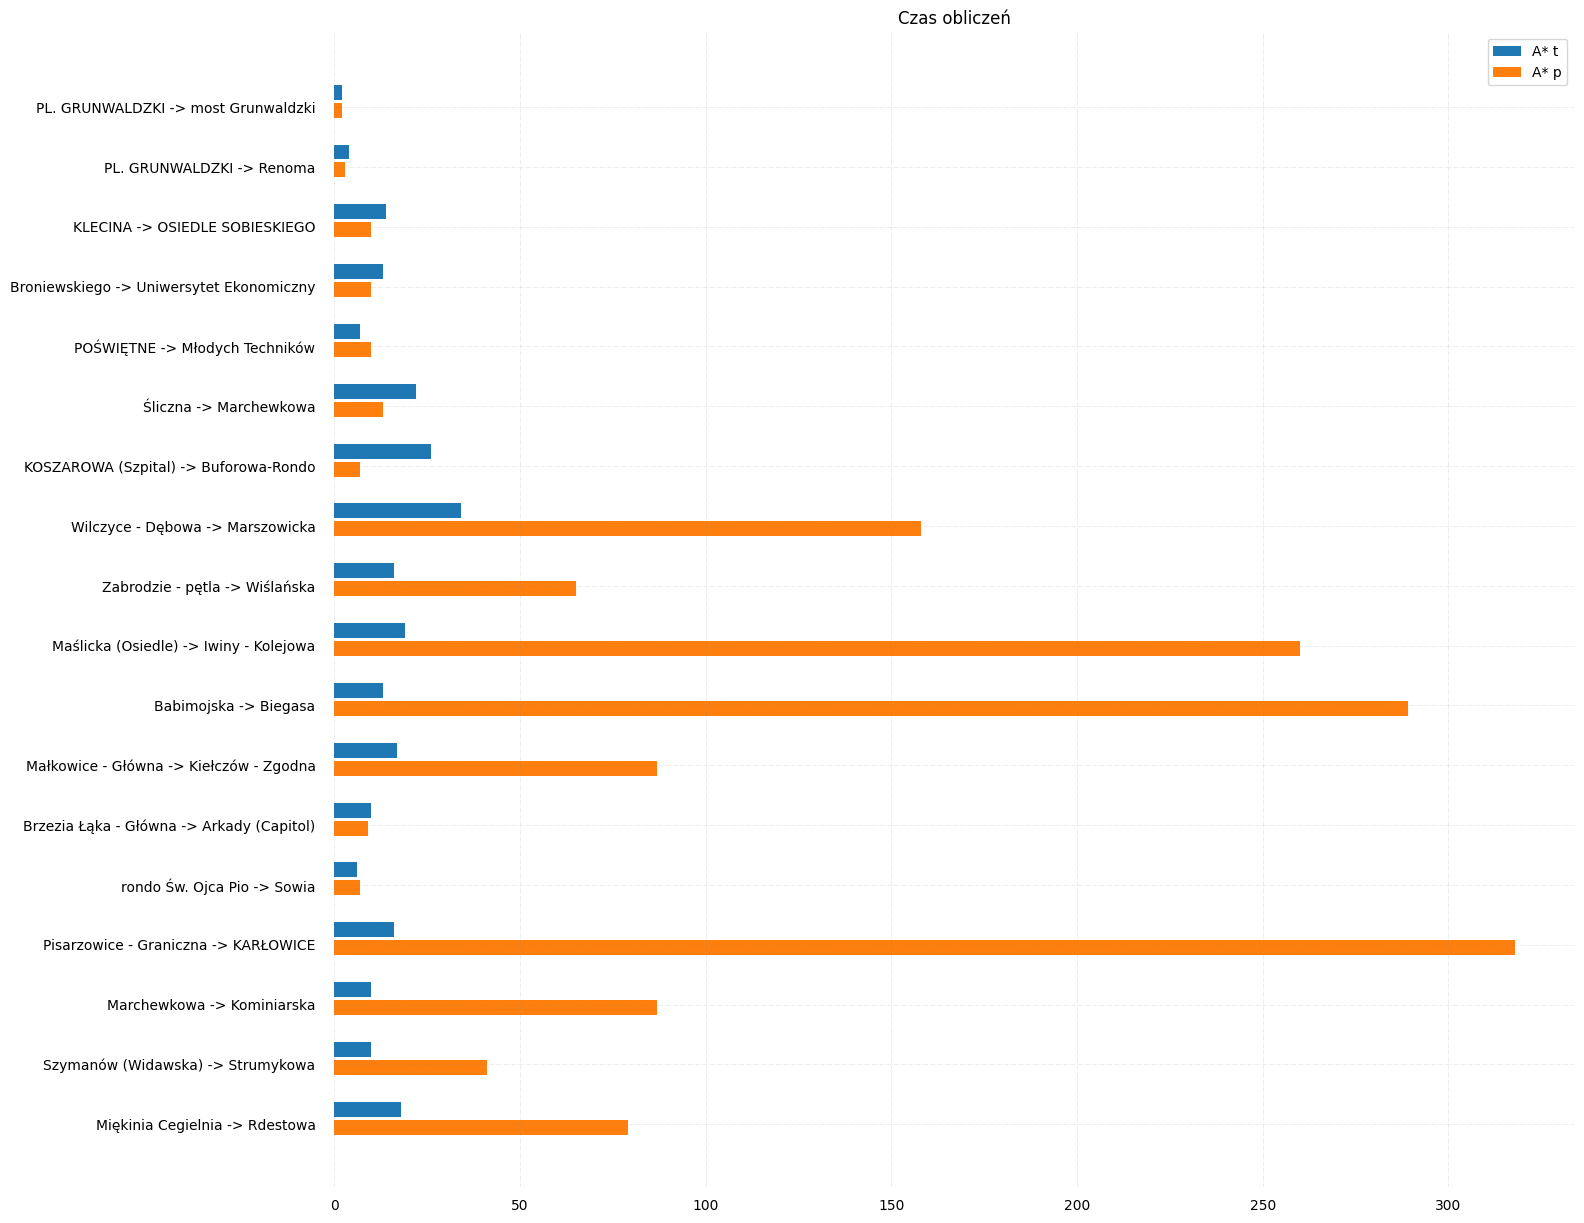

In [31]:
bar_plot_compare([a_star_t, a_star_p], ['A* t', 'A* p'], col_idx=4, title='Czas obliczeń', formatter=int, display_annotation=False)

#### Modyfikacja - optymalizacja czasu i liczby przesiadek 

Modyfikacja dotyczyła zaimplementowania nowej funkcji kosztu i heurystyki, które liczą średnią ważoną kosztów czasu przejazdu i przesiadek A$^*$. Porównując wyniki do $A^* t$ można zauważyć, że odnajduje on prawie tak samo optymalne pod względem czasowym trasy, oraz w porównaniu do $A^*p$ modyfikuje liczbę przesiadek. Wagi dla obu strat zostały wybrane na 'oko', więc prawdopodobnie możliwe byłoby dobranie lepszych wartości tych hiperparametrów. 

Algorytm osiąga bardzo podobne wyniki do  $A^* t$ jeśli chodzi o czas przejazdu, jednak różnie jest z liczbą przesiadek. 

In [32]:
a_star_t_custom = pd.read_csv(RESULTS / 'a-star-custom/summary0', names=header)

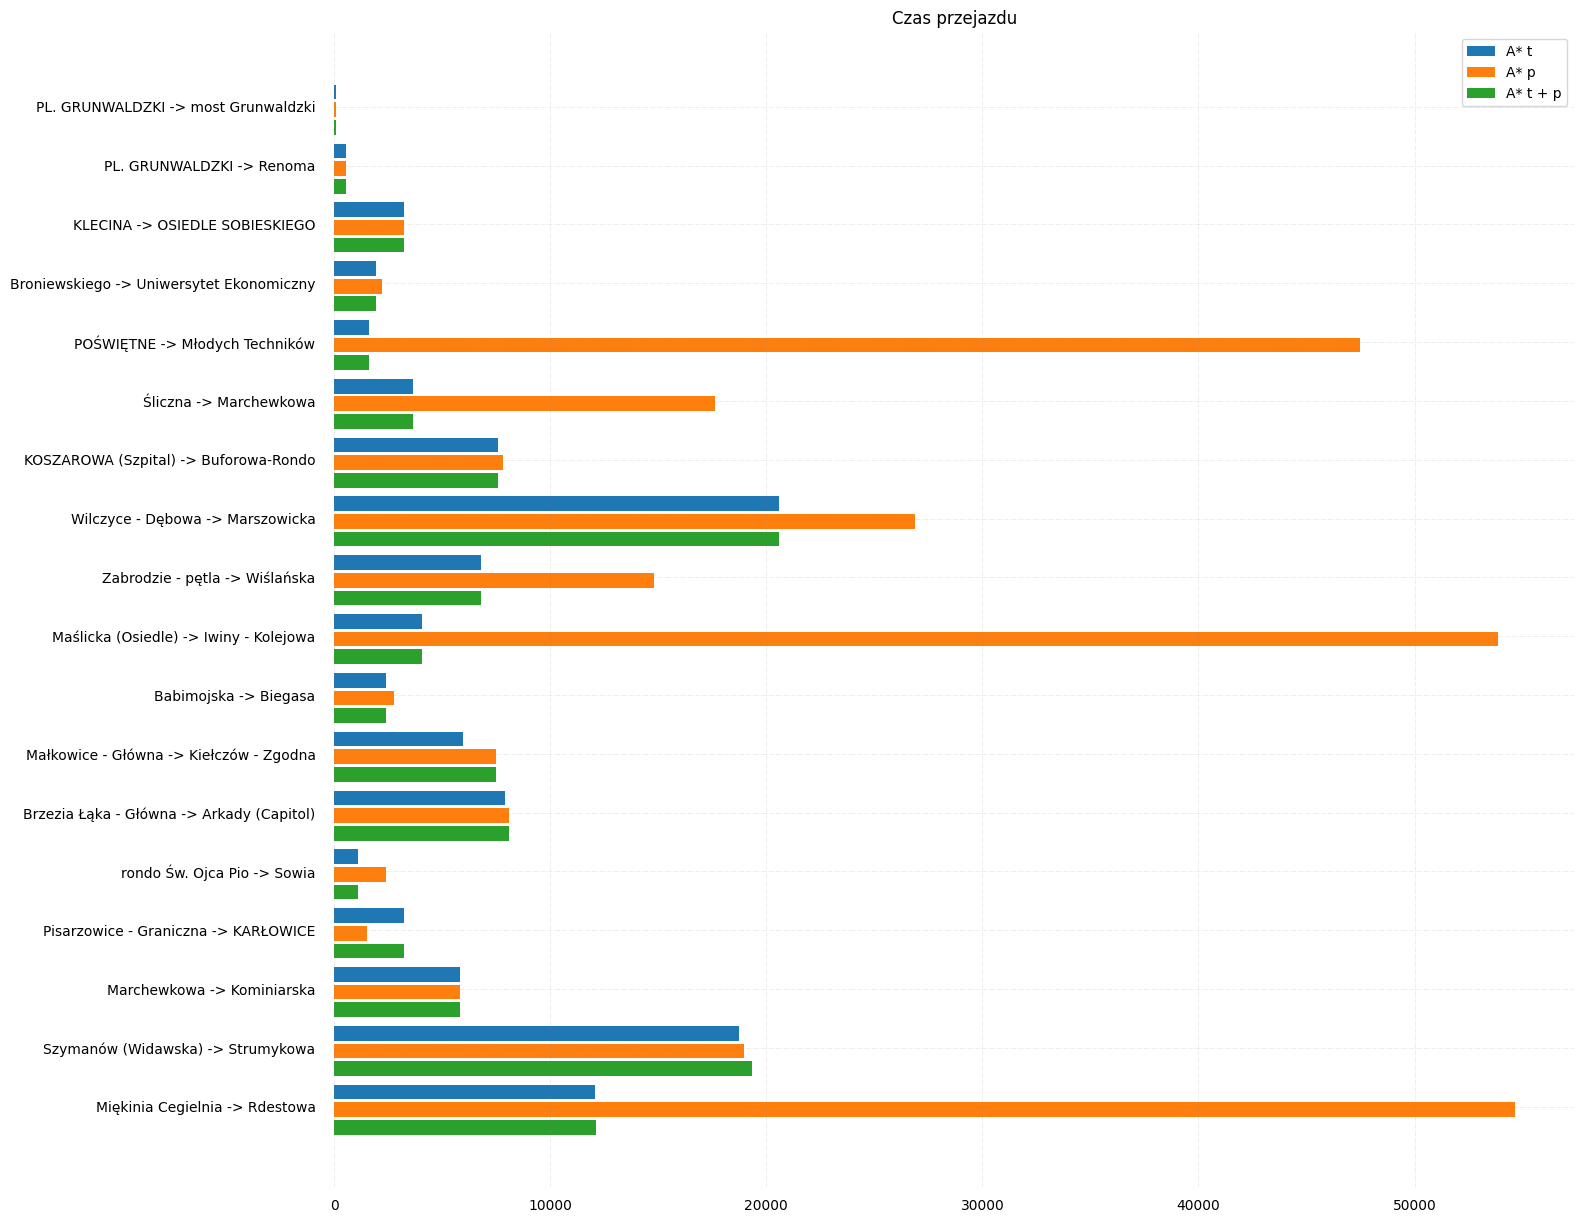

In [33]:
bar_plot_compare([a_star_t, a_star_p, a_star_t_custom], ['A* t', 'A* p', 'A* t + p'], col_idx=2, title='Czas przejazdu', formatter=time_to_normalized_sec, display_annotation=False)

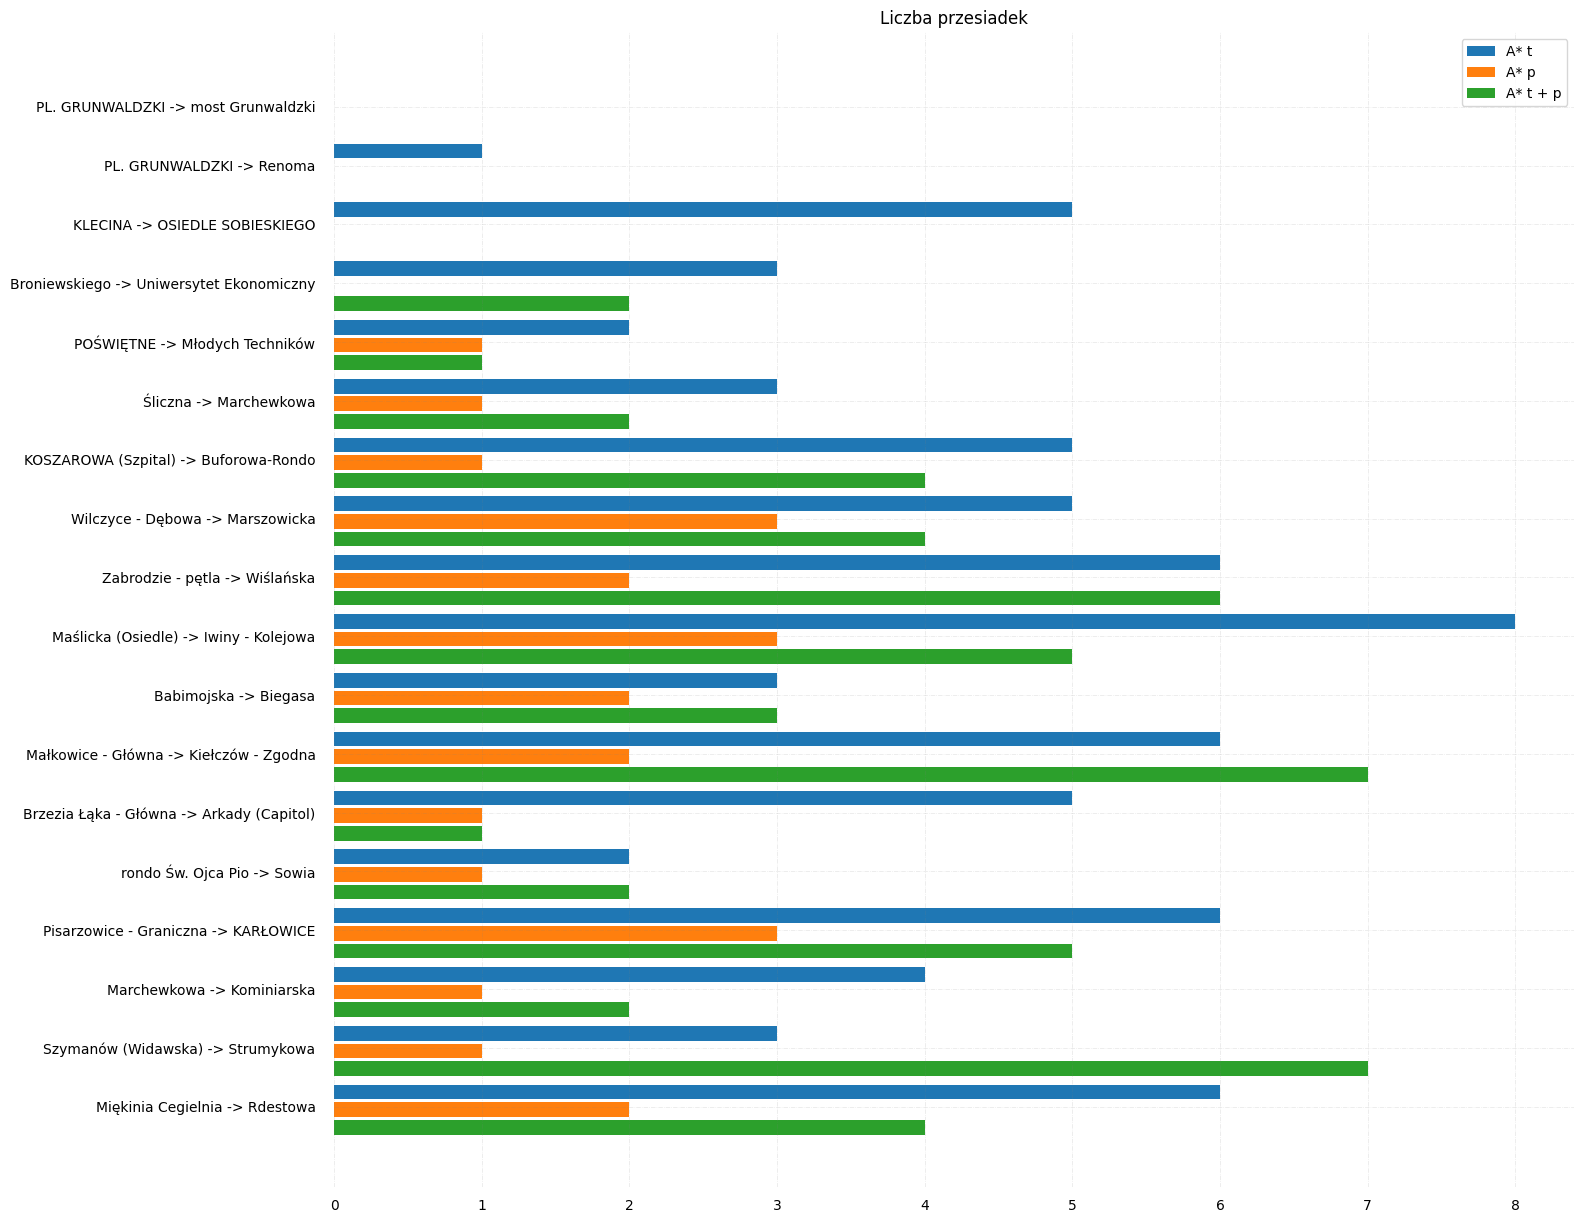

In [34]:
bar_plot_compare([a_star_t, a_star_p, a_star_t_custom], ['A* t', 'A* p', 'A* t + p'], col_idx=3, title='Liczba przesiadek', formatter=int, display_annotation=False)

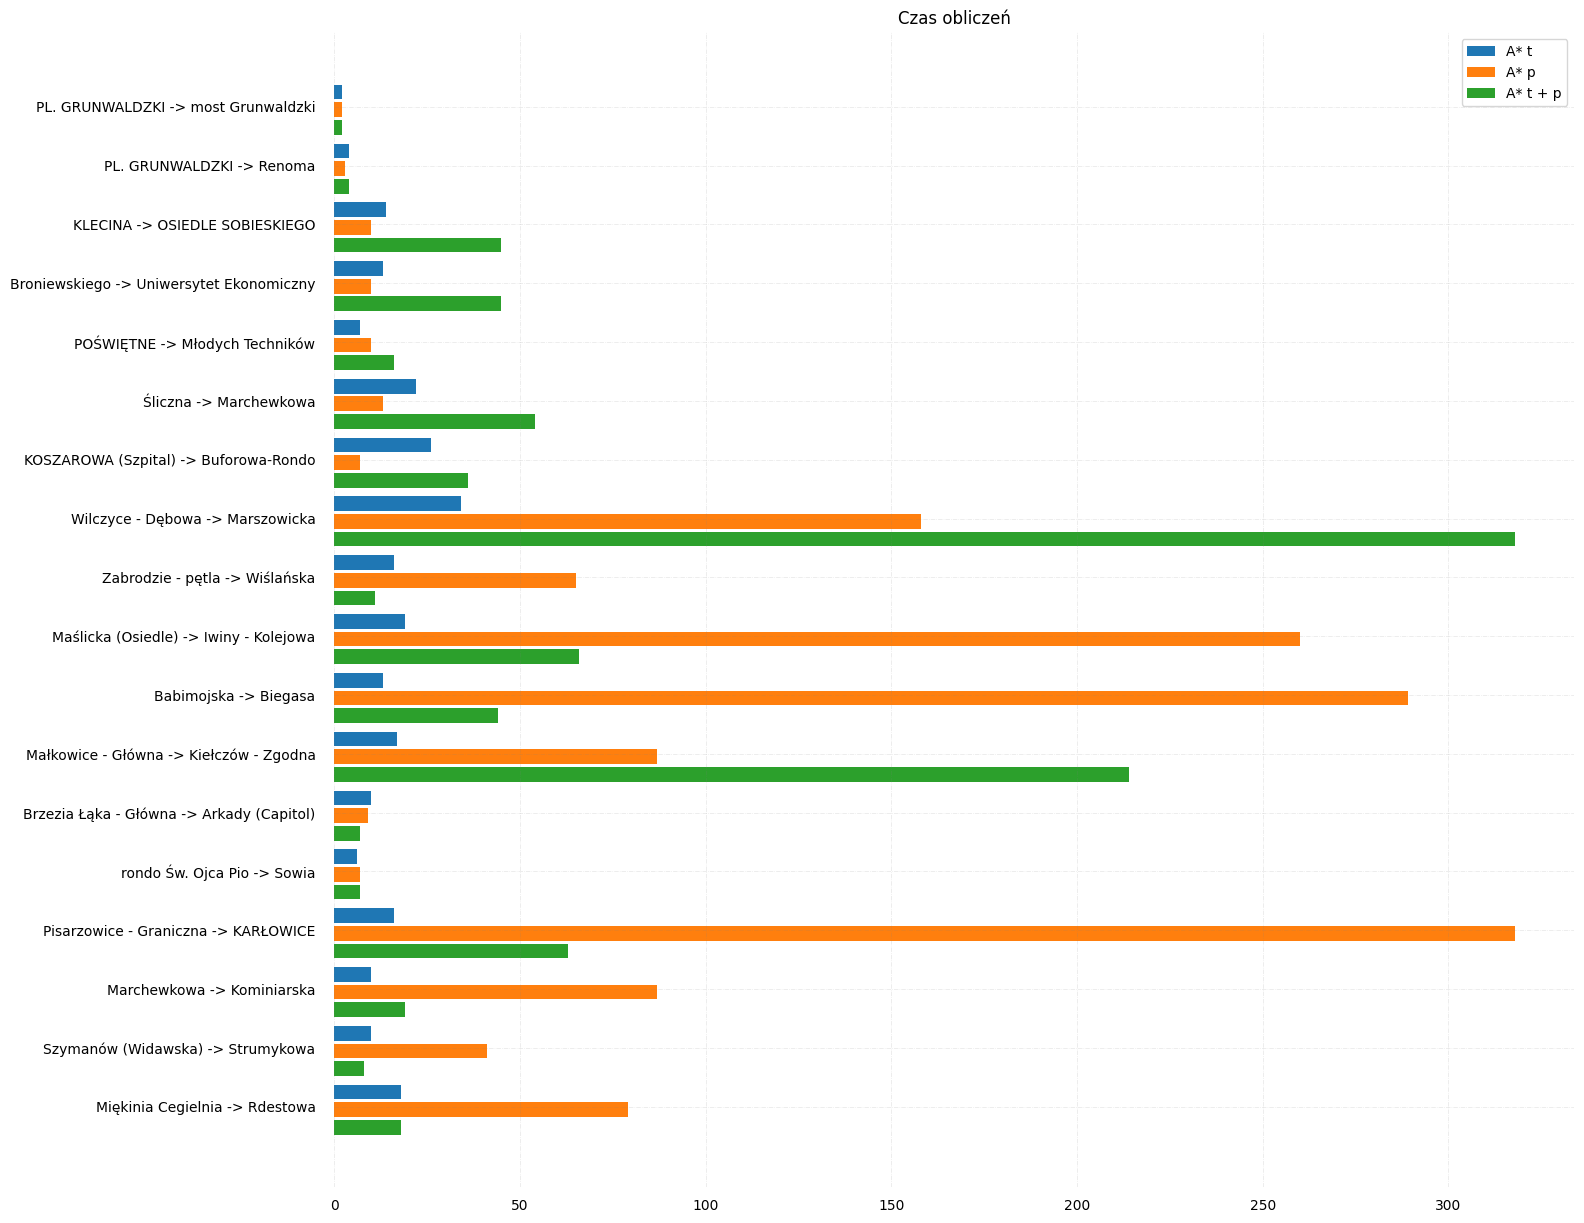

In [35]:
bar_plot_compare([a_star_t, a_star_p, a_star_t_custom], ['A* t', 'A* p', 'A* t + p'], col_idx=4, title='Czas obliczeń', formatter=int, display_annotation=False)

### Tabu Search

Problem przeszukiwania lokalnego został rozwiązany w następujący sposób:
1. Generowane jest początkowe rozwiązanie, które jest połączeniem rozwiązań A* dla dwóch kolejnych par przystanków
2. Następnie rozwiązanie jest poprawiane poprzez permutację, która jest aplikowana od początku ścieżki (powinno to być w stanie wygenerować wszystkie możliwe permutacje)
3. Następnie w zagnieżdżonych pętlach (co odpowiada przeszukiwaniu sąsiedztwa) szukamy lepszego rozwiazania - jeśli go znajdziemy, to zaczynamy przeprowadzać permutacje od początku na tym rozwiązaniu

In [38]:
from ai_data_eng.tabu_search.globals import TABU_SEARCH_DIR_TIME

cases = pd.read_json(DATA_DIR / 'test_cases/tabu-search-cases.json')
results = pd.read_json(TABU_SEARCH_DIR_TIME / 'summary.json')

In [42]:
cases

,start_stop,visiting_stops,leave_hour
0,PL. GRUNWALDZKI,"[most Grunwaldzki, Tramwajowa]",09:00:00
1,GALERIA DOMINIKAŃSKA,"[DWORZEC AUTOBUSOWY, Niedźwiedzia, Tarnogajska]",15:30:00
2,PL. GRUNWALDZKI,"[Krucza, Trzebnicka, Renoma, most Grunwaldzki]",08:00:00
3,Smolecka,"[most Milenijny, Muchobór Wielki, Cynamonowa]",20:30:00


In [39]:
from functools import partial
from ai_data_eng.searching.graph import Graph, add_const_change_time

connection_graph = pd.read_csv(DATA_DIR / 'connection_graph.csv',
                                   usecols=['line', 'departure_time', 'arrival_time', 'start_stop',
                                            'end_stop', 'start_stop_lat', 'start_stop_lon', 'end_stop_lat',
                                            'end_stop_lon'])

g = Graph(connection_graph, partial(add_const_change_time, change_time=0))

C:\Users\julia\AppData\Local\Temp\ipykernel_18512\2316361874.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  connection_graph = pd.read_csv(DATA_DIR / 'connection_graph.csv',


In [44]:
for i in range(len(cases)):
    print(f"TEST CASE {cases.loc[i, 'start_stop']} with stops {cases.loc[i, 'visiting_stops']}")
    print_path_mark_stops([g.conn_at_index(j) for j in results.loc[i, 'conn_idx']], cases.loc[i, 'visiting_stops'])

TEST CASE PL. GRUNWALDZKI with stops ['most Grunwaldzki', 'Tramwajowa']
(0)  PL. GRUNWALDZKI [09:00:00] --- 146 ---> most Grunwaldzki [09:02:00] [851090]
(1) ** most Grunwaldzki [09:02:00] --- 16 ---> PL. GRUNWALDZKI [09:04:00] [280113]
(2)  PL. GRUNWALDZKI [09:04:00] --- 1 ---> Kliniki - Politechnika Wrocławska [09:06:00] [60700]
(3)  Kliniki - Politechnika Wrocławska [09:06:00] --- 1 ---> Hala Stulecia [09:08:00] [60701]
(4)  Hala Stulecia [09:08:00] --- 1 ---> ZOO [09:09:00] [60702]
(5)  ZOO [09:09:00] --- 1 ---> Tramwajowa [09:10:00] [60703]
(6) ** Tramwajowa [09:11:00] --- 4 ---> ZOO [09:13:00] [98160]
(7)  ZOO [09:13:00] --- 4 ---> Hala Stulecia [09:14:00] [98161]
(8)  Hala Stulecia [09:14:00] --- 4 ---> Kliniki - Politechnika Wrocławska [09:16:00] [98162]
(9)  Kliniki - Politechnika Wrocławska [09:16:00] --- 4 ---> PL. GRUNWALDZKI [09:18:00] [98163]
TEST CASE GALERIA DOMINIKAŃSKA with stops ['DWORZEC AUTOBUSOWY', 'Niedźwiedzia', 'Tarnogajska']
(0)  GALERIA DOMINIKAŃSKA [15:30:00